In [100]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [101]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
# Define paths to train and validation data
train_path = '/content/drive/MyDrive/PCA/WatermarkDataset/Train'
val_path = '/content/drive/MyDrive/PCA/WatermarkDataset/Val'

In [103]:
# Load data from train and validation folders
def load_data(folder, target_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

x_train = load_data(train_path)
x_val = load_data(val_path)

In [104]:
# Normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.


In [105]:
# Add noise to images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

In [106]:
# Define the model
input_img = Input(shape=(128, 128, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

In [107]:
# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse')

In [108]:
# Train the model
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val_noisy, x_val))


Epoch 1/50
12/12 [==============================] - 4s 230ms/step - loss: 0.0620 - val_loss: 0.0552
Epoch 2/50
12/12 [==============================] - 2s 206ms/step - loss: 0.0376 - val_loss: 0.0320
Epoch 3/50
12/12 [==============================] - 3s 213ms/step - loss: 0.0289 - val_loss: 0.0264
Epoch 4/50
12/12 [==============================] - 3s 209ms/step - loss: 0.0246 - val_loss: 0.0226
Epoch 5/50
12/12 [==============================] - 3s 210ms/step - loss: 0.0207 - val_loss: 0.0222
Epoch 6/50
12/12 [==============================] - 2s 207ms/step - loss: 0.0191 - val_loss: 0.0193
Epoch 7/50
12/12 [==============================] - 2s 208ms/step - loss: 0.0179 - val_loss: 0.0186
Epoch 8/50
12/12 [==============================] - 3s 216ms/step - loss: 0.0173 - val_loss: 0.0183
Epoch 9/50
12/12 [==============================] - 3s 212ms/step - loss: 0.0170 - val_loss: 0.0189
Epoch 10/50
12/12 [==============================] - 3s 211ms/step - loss: 0.0167 - val_loss: 0.0174

In [109]:
# Save the model
autoencoder.save('denoising_autoencoder_model.h5')

In [110]:
# Load the model
from tensorflow.keras.models import load_model
saved_model = load_model('denoising_autoencoder_model.h5')

In [111]:
# Select 8 random images for demonstration
random_indices = np.random.choice(x_val.shape[0], 8, replace=False)
x_val_sample = x_val[random_indices]
x_val_noisy_sample = x_val_noisy[random_indices]

In [112]:
# Reconstruct images using the saved model
reconstructed_images = saved_model.predict(x_val_noisy_sample)

1/1 [==============================] - 0s 83ms/step


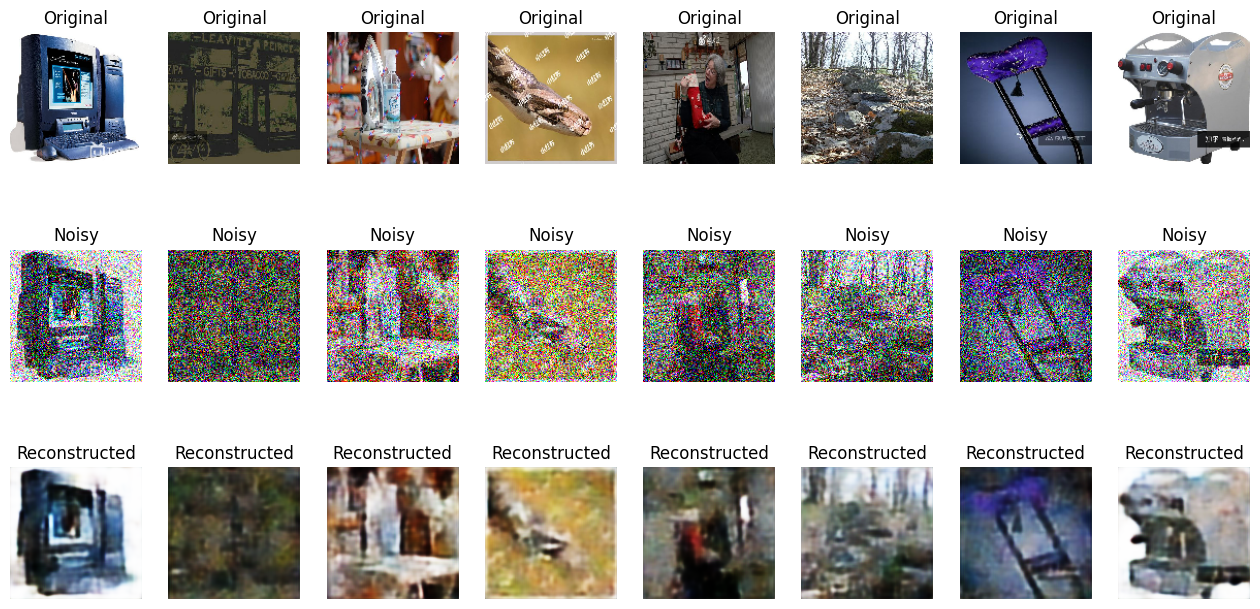

In [113]:
# Plot original, noisy, and reconstructed images
plt.figure(figsize=(16, 8))
for i in range(8):
    # Original
    plt.subplot(3, 8, i + 1)
    plt.imshow(x_val_sample[i])
    plt.title('Original')
    plt.axis('off')

    # Noisy
    plt.subplot(3, 8, i + 9)
    plt.imshow(x_val_noisy_sample[i])
    plt.title('Noisy')
    plt.axis('off')

    # Reconstructed
    plt.subplot(3, 8, i + 17)
    plt.imshow(reconstructed_images[i])
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()